In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Sklearn
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# SQL
import sqlite3

# Data Selection

In [2]:
def sql_preprocess(cursor, table, columns):
    # Select the columns
    cursor.execute(f'''
        CREATE TEMP TABLE filtered_col AS
        SELECT {", ".join(columns)} FROM {table}
    ''')

    # Identify numeric columns
    cursor.execute(f'PRAGMA table_info(filtered_col)')
    columns_info = cursor.fetchall()
    numeric_cols = [col[1] for col in columns_info if col[2] in ('INTEGER', 'REAL')]

    # Null condition
    null_condition = ' AND '.join(f'{col} IS NOT NULL' for col in numeric_cols)
    cursor.execute(f'''
        CREATE TEMP TABLE filtered_null AS
        SELECT * FROM filtered_col
        WHERE {null_condition}
    ''')

    # Group by day
    cursor.execute(f'''
        CREATE TEMP TABLE filtered_day AS
        SELECT 
            COUNT(*) AS row_count,
            DATE(utc_timestamp) AS utc_day,
            {', '.join([f'AVG({col}) AS {col[3:]}_avg' for col in numeric_cols])}
        FROM filtered_null
        GROUP BY utc_day
    ''') # DATE(SUBSTR(cet_cest_timestamp, 1, 19)) AS cet_day

    return 'filtered_day'

def sql_reader(db_path, table):
    conn = sqlite3.connect(db_path) # Connect to the SQLite database
    cursor = conn.cursor() # Declare a cursor

    # Get the columns matching the pattern
    cursor.execute(f"""
        SELECT name
        FROM pragma_table_info('{table}')
        WHERE name LIKE '%timestamp%' OR name LIKE 'BE%'               
    """)
    columns = [row[0] for row in cursor.fetchall()]

    # Preprocess
    filtered_table = sql_preprocess(cursor, table, columns)
    df = pd.read_sql_query(f"SELECT * FROM {filtered_table}", conn, parse_dates=['utc_day'])

    conn.commit()
    conn.close()

    return df

In [6]:
df_cons = sql_reader('../DB/time_series.sqlite', 'time_series_60min_singleindex')
df_weather = sql_reader('../DB/weather_data.sqlite', 'weather_data')

In [7]:
db_path = '../DB/energy_weather.sqlite' # Create the database
conn = sqlite3.connect(db_path) # Connect to the SQLite database
# Create tables from dataframes
df_cons.to_sql('consumption', conn, if_exists='replace', index=False)
df_weather.to_sql('weather', conn, if_exists='replace', index=False)
# Create joined table based on utc_day
cons_select = [f'c.{col}' for col in df_cons.columns if col != 'utc_day']
weather_select = [f'w.{col}' for col in df_weather.columns if col not in df_cons.columns]
select_clause = ", ".join(cons_select + weather_select)
conn.execute("DROP TABLE IF EXISTS joined_data")
join_query = f"""
    CREATE TABLE joined_data AS
    SELECT 
        c.utc_day,
        {select_clause}
    FROM consumption c
    INNER JOIN weather w ON c.utc_day = w.utc_day
""" # STRFTIME('%Y', c.utc_day) AS year, STRFTIME('%m', c.utc_day) AS month, STRFTIME('%w', c.utc_day) AS day_of_week,
conn.execute(join_query)
df_joined = pd.read_sql_query(f"SELECT * FROM joined_data", conn, parse_dates=['utc_day'])
conn.commit()
conn.close()
df_joined.head(5)

,utc_day,row_count,load_actual_entsoe_transparency_avg,load_forecast_entsoe_transparency_avg,solar_generation_actual_avg,wind_generation_actual_avg,wind_offshore_generation_actual_avg,wind_onshore_generation_actual_avg,temperature_avg,radiation_direct_horizontal_avg,radiation_diffuse_horizontal_avg
0,2015-01-01,16,9302.750000,10128.375000,239.304375,1327.441250,640.738750,686.702500,0.478875,16.781469,24.558072
1,2015-01-02,24,9977.791667,9964.000000,88.245000,1230.979167,614.502500,616.476667,3.592583,6.822604,24.647204
2,2015-01-03,24,10167.041667,10112.666667,11.927500,528.915833,285.200833,243.715000,1.103125,0.307500,12.280505
3,2015-01-04,24,9925.166667,9559.083333,152.966250,220.054583,92.094583,127.960000,0.753250,27.074776,21.287341
4,2015-01-05,24,11618.875000,10904.708333,131.757083,327.642083,142.565417,185.076667,-0.065750,2.537711,24.178427


In [5]:
# Display curves against utc_day using plotly and render in browser
import plotly.express as px
fig = px.line(df_joined, x='utc_day', y=df_joined.columns[2:])
fig.show(renderer="browser")

# Data Preprocessing

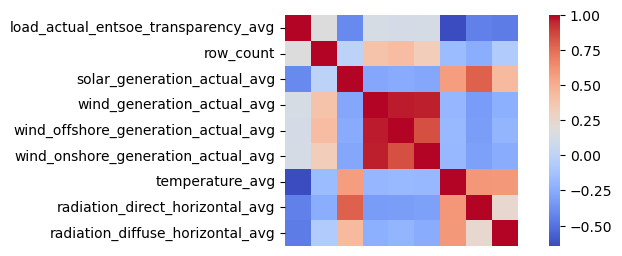

Outlier counts per column:
row_count                              351
solar_generation_actual_avg              0
wind_generation_actual_avg              11
wind_offshore_generation_actual_avg      9
wind_onshore_generation_actual_avg      47
temperature_avg                          0
radiation_direct_horizontal_avg          0
radiation_diffuse_horizontal_avg         0
dtype: int64


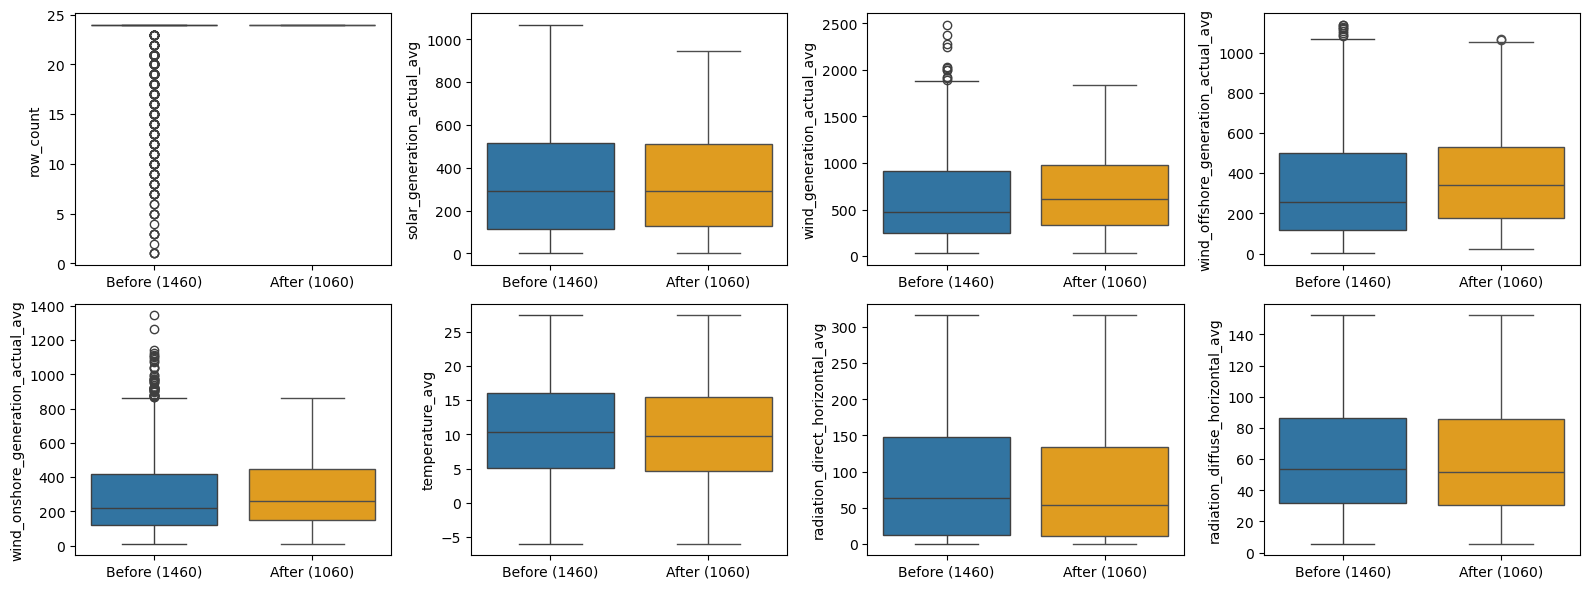

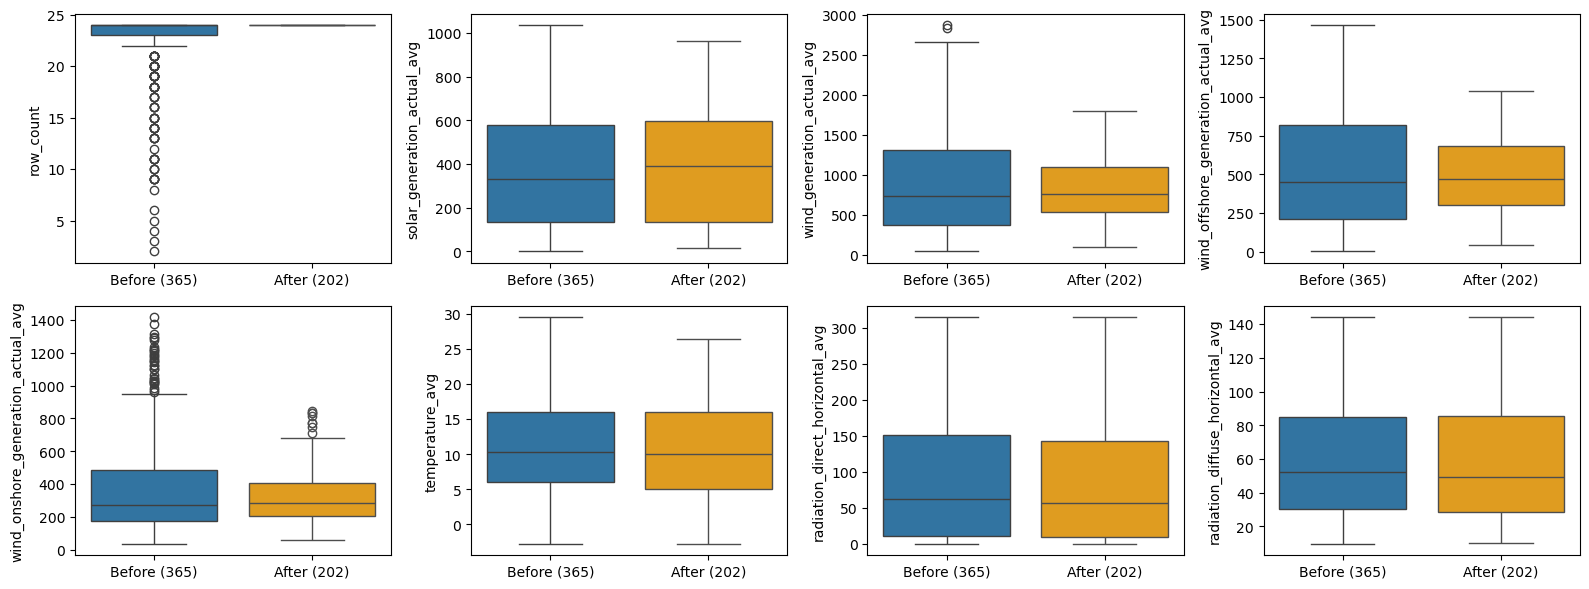

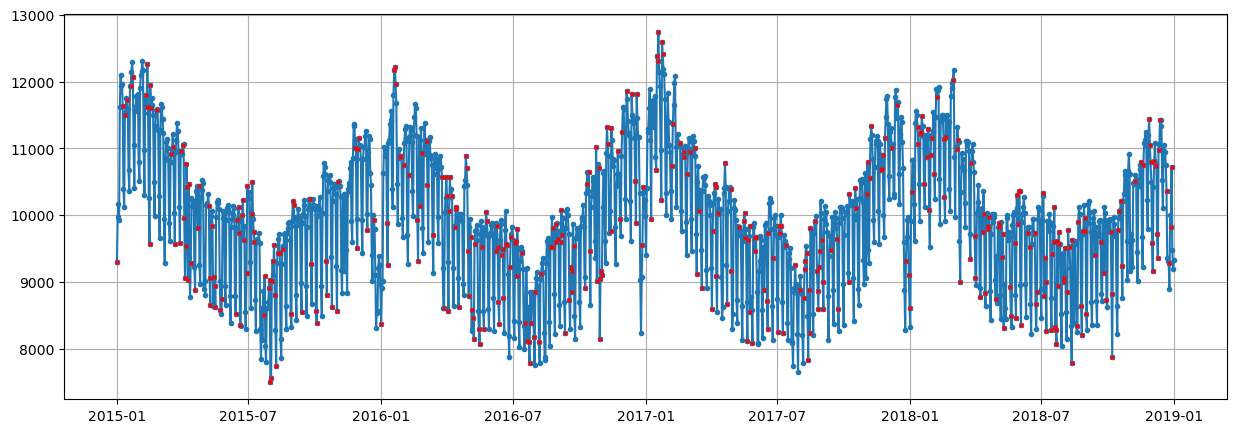

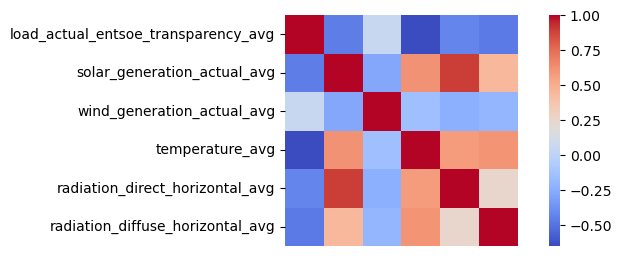

In [113]:
'''
Apply the required steps to produce a regression model (no matter which model) in order to determine the load_actual as a function of other variables:
1) Create the training and test set
2) Plot a correlation heatmap for the raw training set
3) Remove outliers in the training set using the method of your choice and apply the outlier filtering to the test set
4) Apply a correlation filter in the training set to remove highly correlated columns and apply the filtering to the test set
5) Plot a correlation heatmap for the cleaned training set
NB : Normalise when needed
'''

df = df_joined.copy()

# Time information -> One-Hot Encoding
# df['year'] = df['utc_day'].dt.year
# df['month'] = df['utc_day'].dt.month
df['day_of_week'] = df['utc_day'].dt.day_name()

target = 'load_actual_entsoe_transparency_avg'
features = [c for c in df.select_dtypes(exclude=[np.datetime64]).columns.tolist() if c != target]
features.remove('load_forecast_entsoe_transparency_avg')

X = df[features].copy()
y = df[target].copy()

numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Time-series dataset --> Chronological split (avoid breaking the temporal order):
# Training data comes from earlier time periods, while test data comes from later time periods
split_index = int(len(X) * 0.8) # test_size = 0.2
# Avoid data leakage from future to past
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

def plot_corr_heatmap(df_plot):
    plt.figure(figsize=(4,3))
    corr = df_plot.select_dtypes(include=[np.number]).corr()
    sns.heatmap(corr, annot=False, cmap='coolwarm', xticklabels=False, yticklabels=True, cbar=True, cbar_kws={'orientation': 'vertical', 'pad': 0.1})
    plt.show()

plot_corr_heatmap(pd.concat([y_train, X_train], axis=1))

def outlier_filter(df_in, iqr_multiplier=1.5): # Using IQR per-feature -> Pay attention that it only looks at 1D-outliers ... Might be a wrong filtering
    df_in = df_in.select_dtypes(include=[np.number])
    lower = df_in.quantile(0.25)
    upper = df_in.quantile(0.75)
    iqr = upper - lower
    lo = lower - iqr_multiplier * iqr
    hi = upper + iqr_multiplier * iqr
    mask = df_in.apply(lambda col: (col >= lo[col.name]) & (col <= hi[col.name]))
    # Count the number of False elements per column in the mask
    print("Outlier counts per column:")
    print((~mask).sum())
    keep = mask.all(axis=1) # Keep rows where all numeric columns are within bounds
    return keep, lo, hi

keep_train, lo_bounds, hi_bounds = outlier_filter(X_train)
X_train_clean = X_train.loc[keep_train].copy()
y_train_clean = y_train.loc[keep_train].copy()
# Apply same bounds to test
mask_test = X_test.select_dtypes(include=[np.number]).apply(lambda col: (col >= lo_bounds[col.name]) & (col <= hi_bounds[col.name]))
keep_test = mask_test.all(axis=1)
X_test_clean = X_test.loc[keep_test].copy()
y_test_clean = y_test.loc[keep_test].copy()

# Create a subfigure of boxplots for each (normalised) feature before and after outlier removal
def plot_boxplot(df_in, df_in_filtered):
    df_in = df_in.select_dtypes(include=[np.number])
    df_in_filtered = df_in_filtered.select_dtypes(include=[np.number])
    num_cols = df_in.select_dtypes(include=[np.number]).columns.tolist()
    n_cols = 4
    n_rows = int(np.ceil(len(num_cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
    axes = axes.flatten()
    for i, col in enumerate(num_cols):
        sns.boxplot(x=[f'Before ({df_in[col].size})'] * len(df_in[col]), y=df_in[col], ax=axes[i])
        sns.boxplot(x=[f'After ({df_in_filtered[col].size})'] * len(df_in_filtered[col]), y=df_in_filtered[col], ax=axes[i], color='orange')
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])  # Remove unused subplots
    plt.tight_layout()
    plt.show()

plot_boxplot(X_train, X_train_clean)
plot_boxplot(X_test, X_test_clean)

# Create a plot to show the evolution of y_train as a function of utc_day AND highlight the outliers removed
def target_evolution(y_in, y_in_filtered):
    plt.figure(figsize=(15,5))
    removed_idx = y_in.index.difference(y_in_filtered.index)
    plt.plot(df.loc[y_in.index, 'utc_day'], y_in, marker='o', linestyle='-', markersize=3)
    plt.plot(df.loc[removed_idx, 'utc_day'], df.loc[removed_idx, y_in.name], marker='x', linestyle='None', color='r', markersize=3)
    plt.grid()
    plt.show()

target_evolution(y_train, y_train_clean)

def corr_filter(X_in, corr_tresh=0.9): # Might be managed by regularisation directly
    corr_matrix = X_in.select_dtypes(include=[np.number]).corr().abs()
    upper_triangular = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper_triangular.columns if any(upper_triangular[col] > corr_tresh)]
    return to_drop

# Variance filter independent from the original units
def variance_filter(X_in, cv_tresh=0.01):
    X_in = X_in.select_dtypes(include=[np.number])
    means = X_in.mean().abs()
    stds = X_in.std()
    cv = stds / means.replace(0, np.nan) # coefficient of variation
    to_drop = cv[cv <= cv_tresh].index.tolist() # Remove low variance variables (why ?)
    return to_drop

cols_to_drop = corr_filter(X_train_clean) + variance_filter(X_train_clean, cv_tresh=0)
X_train_final = X_train_clean.drop(columns=cols_to_drop)
X_test_final = X_test_clean.drop(columns=cols_to_drop)

# numerical_cols = [c for c in numerical_cols if c not in cols_to_drop]
# categorical_cols = [c for c in categorical_cols if c not in cols_to_drop]

# date = df.loc[y_test_clean.index, 'utc_day']
date = df.loc[y_test.index, 'utc_day']

plot_corr_heatmap(pd.concat([y_train_clean, X_train_final], axis=1))

# Regression Model

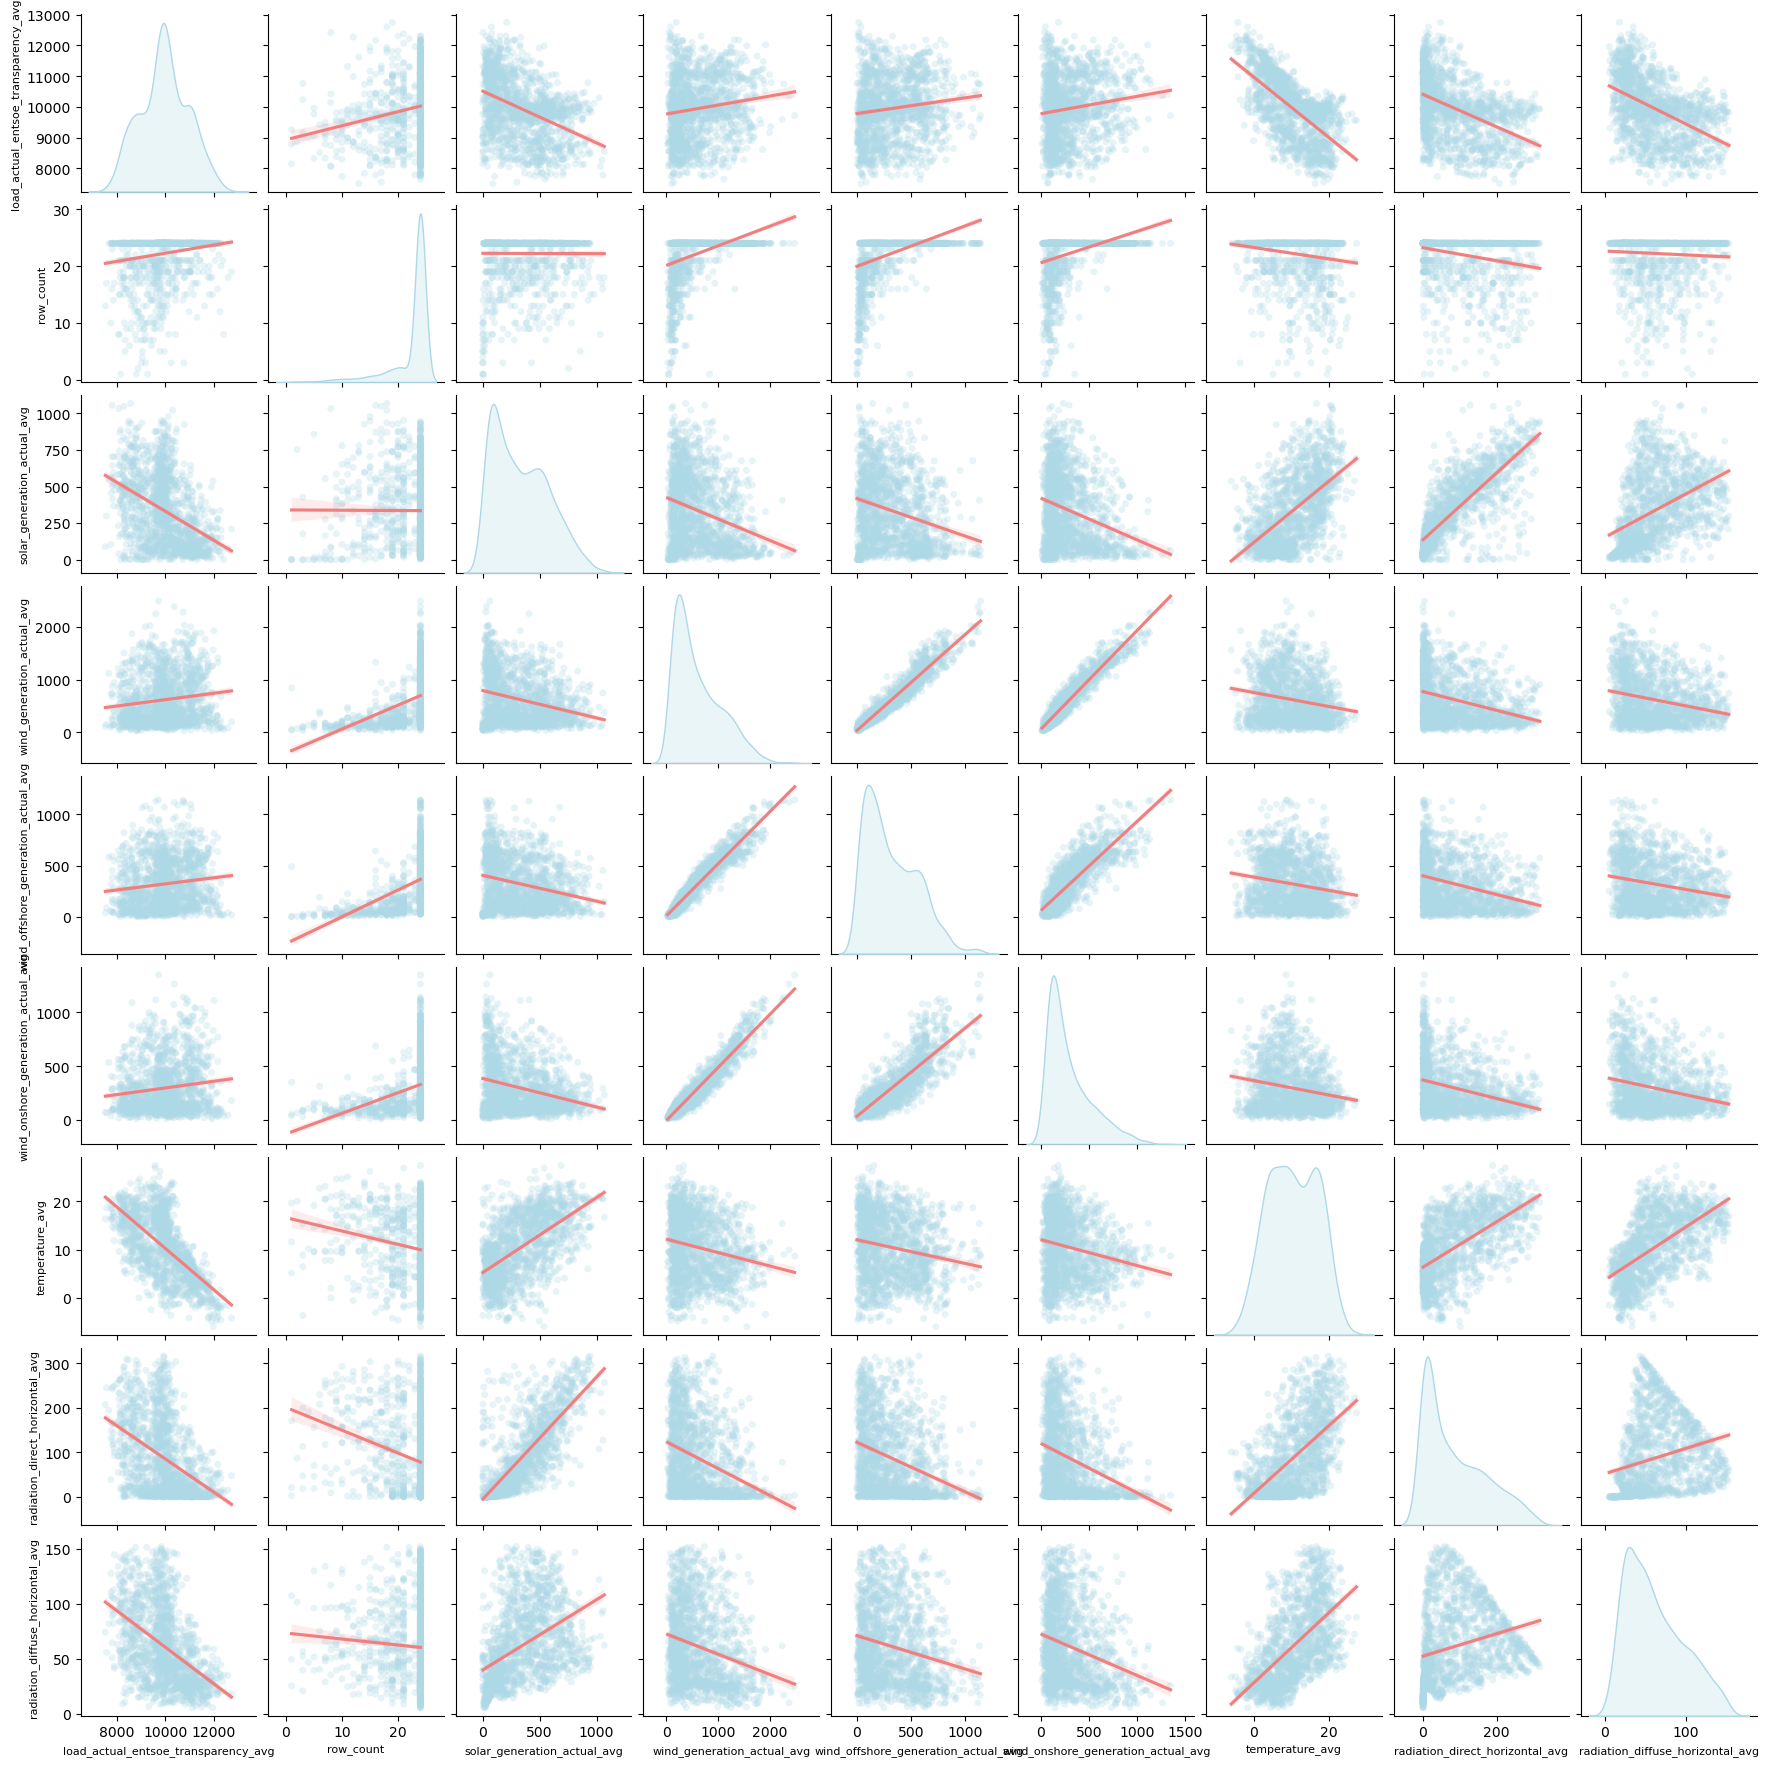

In [114]:
# X_train = X_train_final
# X_test = X_test_final
# y_train = y_train_clean
# y_test = y_test_clean

train = pd.concat([y_train, X_train.loc[:, numerical_cols]], axis=1)

fig = sns.pairplot(
    train,
    kind='reg',
    diag_kind='kde',
    height=2,
    plot_kws={
        'scatter_kws': {
            'alpha': 0.3,
            'edgecolors': 'none',
            'color': 'lightblue',
            's': 25
        },
        'line_kws': {
            'color': 'lightcoral'
        },
    },
    diag_kws={
        'color': 'lightblue'
    }
)

for ax in fig.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)

plt.show()

In [123]:
# Step 1: Define transformers
categorical_transformer = OneHotEncoder(drop='if_binary', sparse_output=False)
numerical_transformer = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

# Step 2: ColumnTransformer to apply different preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ],
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
)

# Step 3: Full pipeline
alphas = np.logspace(-10, 10, 21) # cross-validation
model = Pipeline([
    ('preprocess', preprocessor),
    ('scaler', StandardScaler()),  # scale everything after transformation
    ('regressor', LassoCV(alphas=alphas, max_iter=1_000_000))
])

# Fit the model
model.fit(X_train, y_train)

# Predict on test
y_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

model # Show the pipeline

c:\Users\dimit\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 103145566.57891202, tolerance: 117559.1266675752

c:\Users\dimit\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 107904937.06115127, tolerance: 113896.7713223156



Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['day_of_week']),
                                                 ('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['row_count',
                                                   'solar_generation_actual_avg',
                                                   'wind_generation_actual_avg',
                                                   'wind_offshore_generation_actual_avg...
                                                   'temperature_avg',
                                                   'radiation_direct_horizontal_avg',
                                                   'radiation_diffuse_horizontal_avg'])],
                                   verbose_feature_names_out=False)),
                ('scaler', StandardScaler()),
                ('regressor',
                 LassoCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
                         max_iter=1000000))])

# Visualisation

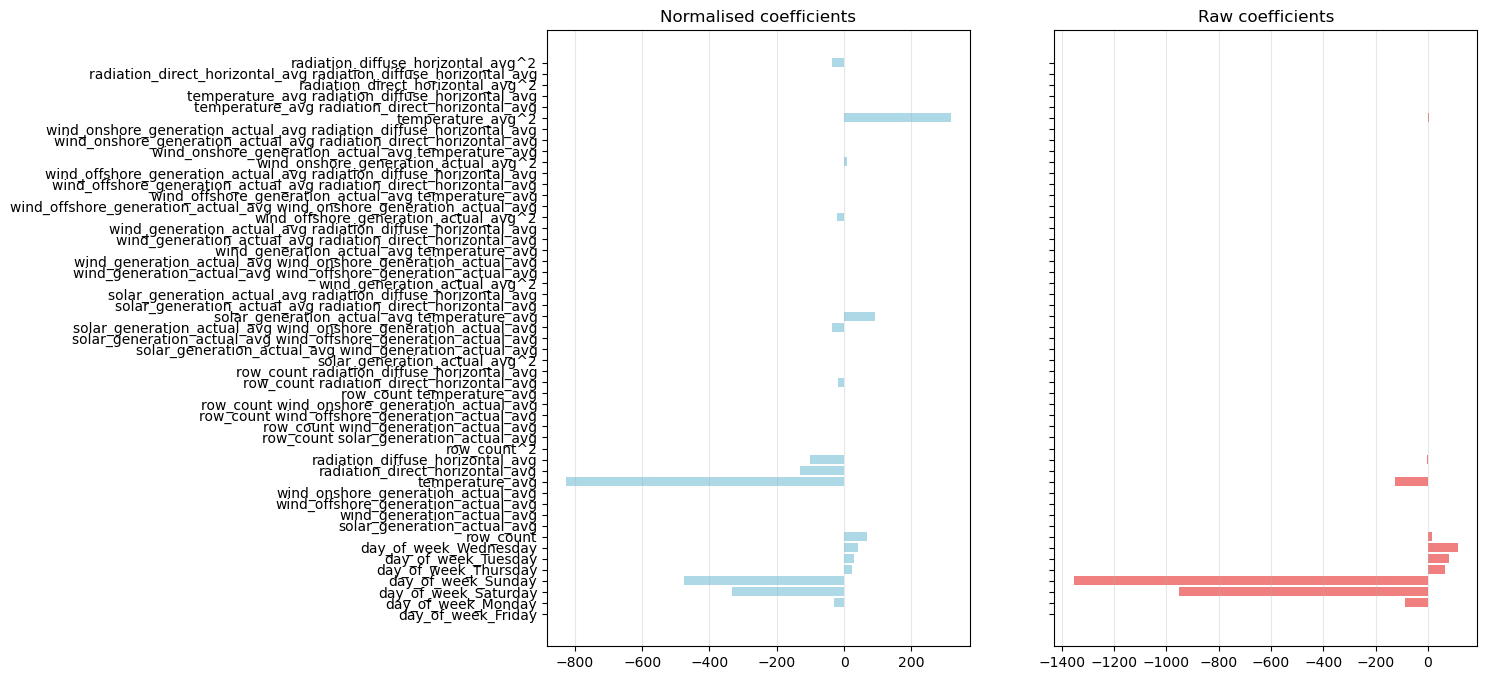

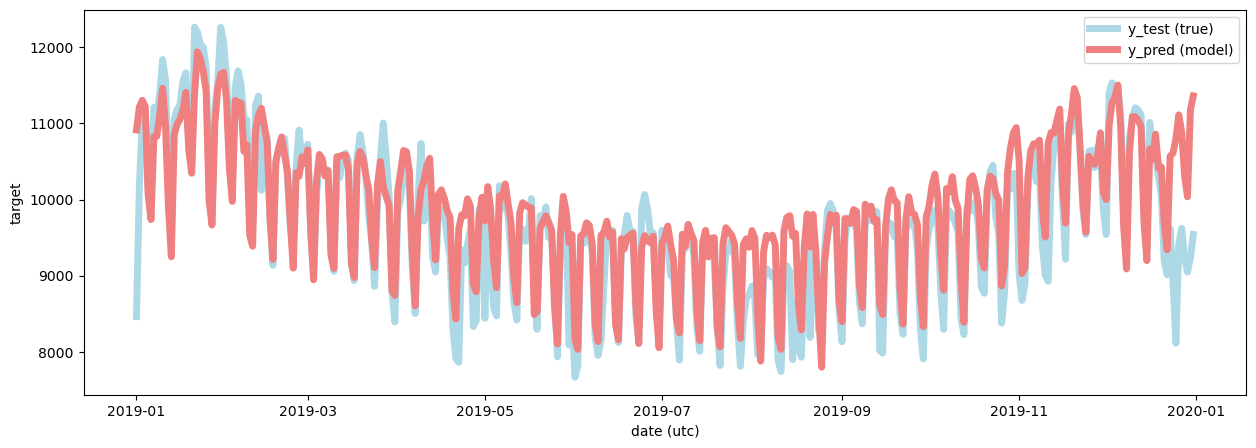

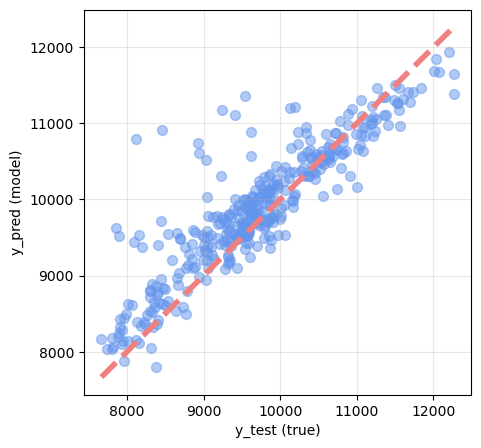

In [124]:
# Symbolic expression
preprocess = model.named_steps.get('preprocess')
scaler = model.named_steps.get('scaler')
reg = model.named_steps.get('regressor')

feature_names = preprocess.get_feature_names_out()

# Features
intercept = reg.intercept_
coefs = reg.coef_

# Build dataframe with coefficients indexed by transformed feature names
df_coefs = pd.DataFrame(
    coefs,
    columns=['coef_normalised'],
    index=feature_names
)

# Unscaling
mu = pd.Series(scaler.mean_, index=feature_names)
sigma = pd.Series(scaler.scale_, index=feature_names)

intercept_raw = intercept  - np.dot(coefs, mu/sigma)
coefs_raw = coefs / sigma

# Normalised coefficients (consistent with CV computation that multiplies coef * std)
df_coefs['coef_raw'] = coefs_raw

y_pred_raw = intercept_raw + np.dot(preprocess.transform(X_test), coefs_raw)

def coef_plot(df_coef):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
    ax[0].barh(df_coef.index, df_coef['coef_normalised'], color='lightblue')
    ax[0].grid(axis='x', alpha=0.3)
    ax[0].set_title('Normalised coefficients')
    ax[1].barh(df_coef.index, df_coef['coef_raw'], color='lightcoral')
    ax[1].grid(axis='x', alpha=0.3)
    ax[1].set_title('Raw coefficients')
    plt.show()

coef_plot(df_coefs)

def line_comparison(date, y_pred, y_true):
    plt.figure(figsize=(15,5))
    plt.plot(date, y_true, label='y_test (true)', linewidth=5, color='lightblue')
    plt.plot(date, y_pred, label='y_pred (model)', linewidth=5, color='lightcoral')
    plt.xlabel('date (utc)')
    plt.ylabel('target')
    plt.legend()
    plt.show()

line_comparison(date, y_pred, y_test)    

def scatter_comparison(y_pred, y_true):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.5, s=50, color='cornflowerblue')
    minv = min(y_true.min(), y_pred.min())
    maxv = max(y_true.max(), y_pred.max())
    plt.plot([minv, maxv], [minv, maxv], linewidth=4, color='lightcoral', linestyle='dashed')
    plt.xlabel('y_test (true)')
    plt.ylabel('y_pred (model)')
    plt.grid(alpha=0.3)
    plt.show()

scatter_comparison(y_pred, y_test)

# Cross-validation

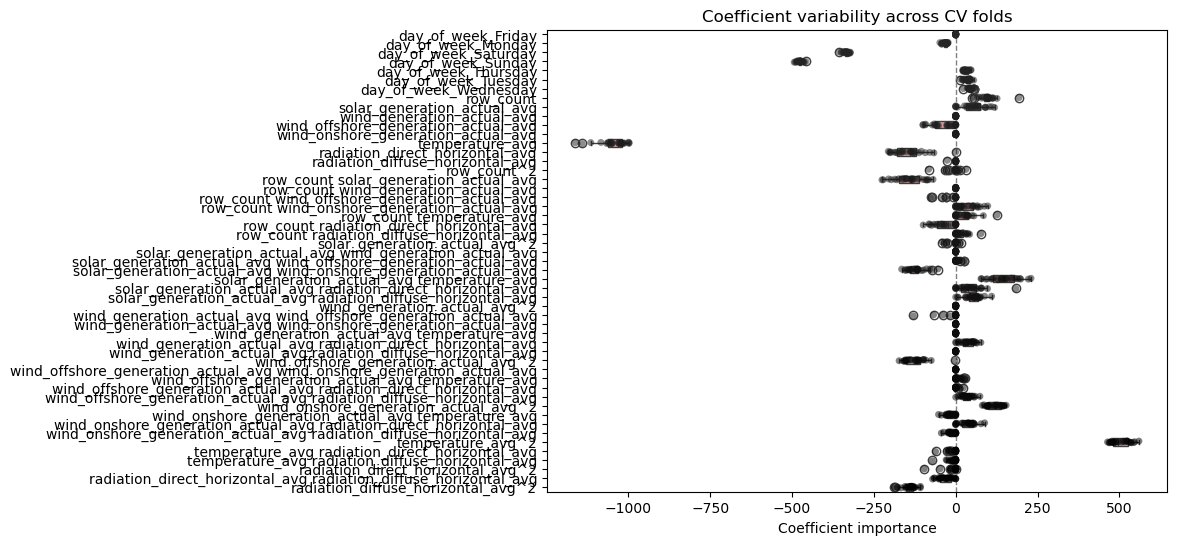

In [125]:
from sklearn.model_selection import RepeatedKFold, cross_validate

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate( # WARNING !!! Working with time-series here !!!
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2
)

coefs_cv_normalised = pd.DataFrame(
    [
        est.named_steps.get('regressor').coef_
        for est, (train_idx, _) in zip(cv_model['estimator'], cv.split(X, y))
    ],
    columns=feature_names
)

def cv_coef_plot(coefs_normalised):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.stripplot(data=coefs_cv_normalised, orient='h', palette='dark:k', alpha=0.5) # To show every points
    sns.boxplot(data=coefs_cv_normalised, orient='h', ax=ax, color='lightcoral', saturation=0.5, whis=1.5) # whisker length ; (IQR = Q1-Q3) -> whisker = k*IQR ; Outliers are outside the "min-max" region (but are not necessarily wrong values)
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_title('Coefficient variability across CV folds')
    ax.set_xlabel('Coefficient importance')
    plt.show()

cv_coef_plot(coefs_cv_normalised)

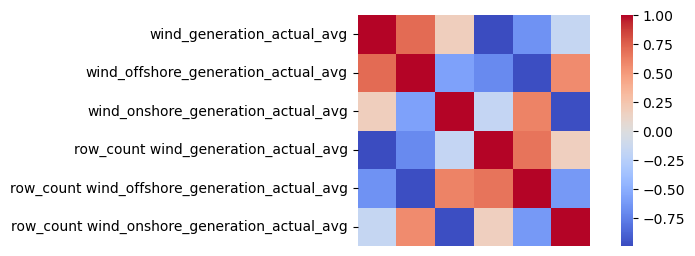

In [120]:
def corr_filter(X_in, corr_tresh=0.9):
    corr_matrix = X_in.corr().abs()
    corr_matrix_filtered = corr_matrix.where(corr_matrix > corr_tresh).dropna(axis=1, thresh=2)
    to_keep = corr_matrix_filtered.columns
    return to_keep

def plot_corr_heatmap(df_plot):
    plt.figure(figsize=(4,3))
    corr = df_plot.corr()
    sns.heatmap(corr, annot=False, cmap='coolwarm', xticklabels=False, yticklabels=True, cbar=True, cbar_kws={'orientation': 'vertical', 'pad': 0.1})
    plt.show()

to_keep = corr_filter(coefs_cv_normalised, 0.95)
coefs_cv_normalised_correlated = coefs_cv_normalised.loc[:, to_keep]

plot_corr_heatmap(coefs_cv_normalised_correlated)